# COMP 541 - Deep Learning Course Fall 2020
## Project
### Berk Güler - berkguler20@ku.edu.tr

In [1]:
import Pkg; Pkg.add("IterTools"); Pkg.add("Knet"); Pkg.add("Plots"); Pkg.add("CUDA");
using Knet: Knet, dir, accuracy, progress, sgd, load, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout
using Statistics: mean
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Plots
using DelimitedFiles, Statistics, Random
import CUDA
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
dataset_directory_path = "../Tubitak ANN/DATA"
dataset_directory = filter(x -> isdir(joinpath(dataset_directory_path, x)), readdir(dataset_directory_path))

   Updating registry at `C:\Users\berkg\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`


7-element Array{String,1}:
 "doganay_experiment"
 "idil_experiment"
 "istenc_experiment"
 "omer_experiment"
 "ozan_experiment"
 "yahya_experiment"
 "zaid_experiment"

## Data Preprocessing

### Read and Assign all of the data

In [70]:
function split_and_convert(string_array,splitter)
    Rlength = length(string_array)
    Clength = length(split(string_array[1],splitter))
    Mdata = zeros(Float64,Rlength,Clength)
    for i in 1:Rlength
        row =  map(x->tryparse(Float64,x),split(string_array[i],splitter))
        Mdata[i,:] = row
    end
    return Mdata
end

split_and_convert (generic function with 1 method)

In [71]:
test_data = Array{Float32}(undef,0,10)
train_data = Array{Float32}(undef,0,10)

for participant_index in 1:length(dataset_directory)
    #Participants: 1.doganay 2.idil 3.istenc 4.omer 5.ozan 6.yahya 7.zaid
    participant_directory_path = joinpath(dataset_directory_path,dataset_directory[participant_index])
    participant_directory = readdir(participant_directory_path)
    if participant_index != 5
        for raw_txt_files in participant_directory
            txt_file_directory_path = joinpath(participant_directory_path, raw_txt_files)
            txt_file_directory = readdir(txt_file_directory_path)
            
            raw_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[4]))
            raw_data = split_and_convert(readlines(raw_data_file),",")
            close(raw_data_file)
            
            time_trimmer = 1:size(raw_data)[1]
            
            time_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[9]))
            time_raw_data = split_and_convert(readlines(time_data_file)," ")
            time_data = time_raw_data[time_trimmer,2].-time_raw_data[1,2]
            
            # Time  Position Velocity F_fint F_int F_h m b a subtask 
            #  1        2       3        4     5    6  7 8 9    10     
            train_data = [train_data; time_data raw_data]
        end
    else
        for raw_txt_files in participant_directory
            txt_file_directory_path = joinpath(participant_directory_path, raw_txt_files)
            txt_file_directory = readdir(txt_file_directory_path)
    
            raw_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[4]))
            raw_data = split_and_convert(readlines(raw_data_file),",")
            close(raw_data_file)
            
            time_trimmer = 1:size(raw_data)[1]
            
            time_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[9]))
            time_raw_data = split_and_convert(readlines(time_data_file)," ")
            time_data = time_raw_data[time_trimmer,2].-time_raw_data[1,2]
            
            # Time  Position Velocity F_fint F_int F_h m b a subtask 
            #  1        2       3        4     5    6  7 8 9    10       
            test_data = [test_data; time_data raw_data]
        end
    end
end

In [73]:
time_history = 25;
ARRAY = Array{Float32}

Array{Float32,N} where N

#### One Hot Encoding

In [74]:
onehot(y) = (m = zeros(eltype(ARRAY),length(y),3); for i in 1:length(y);  m[i,y[i]]=1; end; ARRAY(m))

onehot (generic function with 1 method)

#### Normalizing

In [75]:
function normalize(x)
    return (x .- mean(x,dims=1)) ./ std(x,dims=1);
end

normalize (generic function with 1 method)

In [78]:
x_raw_train = [train_data[:,1] train_data[:,3] train_data[:,4] train_data[:,6]]; # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
x_raw_test  = [test_data[:,1] test_data[:,3] test_data[:,4] test_data[:,6]]; # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
y_train = onehot(convert(Array{Int32},train_data[:,end]));
y_test  = onehot(convert(Array{Int32},test_data[:,end]));

In [79]:
print(size(x_raw_train),size(x_raw_test),size(y_train),size(y_test))

(474619, 4)(86220, 4)(474619, 3)(86220, 3)

#### Sliding Time Window Approach

In [80]:
function slide_time(vector_raw, time_history__)
    X = Array{Float64}(undef,length(vector_raw),time_history__)
    buffer = ones(1,time_history__).*vector_raw[1]
    for i = 1:length(vector_raw)
        X[i,:] = buffer;
        buffer = [buffer[2:end]' vector_raw[i]];
    end
    return X
end

slide_time (generic function with 1 method)

In [81]:
function slide_time_window(x_raw, time_history_) # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
    buffer = ones(1,time_history_)
    time = x_raw[:,1]
    velocity = x_raw[:,2]
    ffint = x_raw[:,3]
    fh = x_raw[:,4]
    velocity_history = slide_time(velocity,time_history_);
    ffint_history = slide_time(ffint,time_history_);
    fh_history = slide_time(fh,time_history_);
    return [time normalize(velocity_history) normalize(velocity) normalize(ffint_history) normalize(ffint) normalize(fh_history) normalize(fh)]
end

slide_time_window (generic function with 1 method)

In [82]:
x_train = slide_time_window(x_raw_train,time_history);
x_test = slide_time_window(x_raw_test,time_history);

## Visualizing the DATA

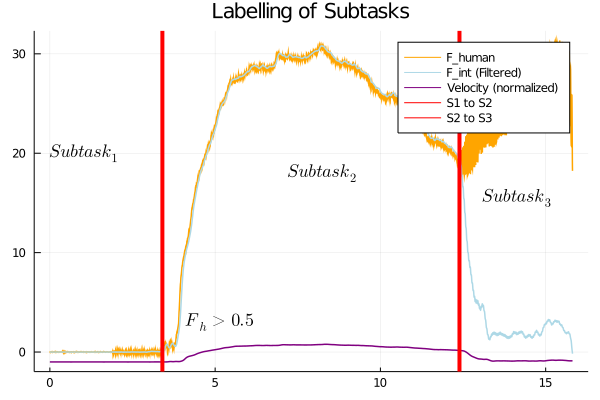

In [83]:
first_x_raw = x_raw_train[1:7907,:]
first_y_raw = train_data[1:7907,end];
sub1_sub2 = findall(x-> 3>x>1,first_y_raw)[1]
sub2_sub3 = findall(x-> x>2,first_y_raw)[1]
plot(first_x_raw[:,1],first_x_raw[:,4], title = "Labelling of Subtasks",  label = "F_human" ,lw = 1.5, fmt = :png, linecolor = "Orange")
plot!(first_x_raw[:,1],first_x_raw[:,3], label= "F_int (Filtered)", lw = 1.5, linecolor="LightBlue")
plot!(first_x_raw[:,1],x_train[1:7907,2], label= "Velocity (normalized)", lw = 1.5, linecolor="Purple")
plot!([first_x_raw[sub1_sub2,1]], seriestype="vline", lw = 4, linecolor = "Red", label ="S1 to S2")
plot!([first_x_raw[sub2_sub3,1]], seriestype="vline", lw = 4, linecolor = "Red", label ="S2 to S3")
annotate!(first_x_raw[sub1_sub2,1]+0.7, 3, text("\$F_h > 0.5 \$",Plots.font("Tahoma", 12),  :left))
annotate!(0, 20, text("\$Subtask_1 \$",Plots.font("Tahoma", 12),  :left))
annotate!(first_x_raw[sub1_sub2,1]+ 3.8, 18, text("\$Subtask_2 \$",Plots.font("Tahoma", 12),  :left))
annotate!(first_x_raw[sub2_sub3,1]+ 0.7, 15.5, text("\$Subtask_3 \$",Plots.font("Tahoma", 12),  :left))

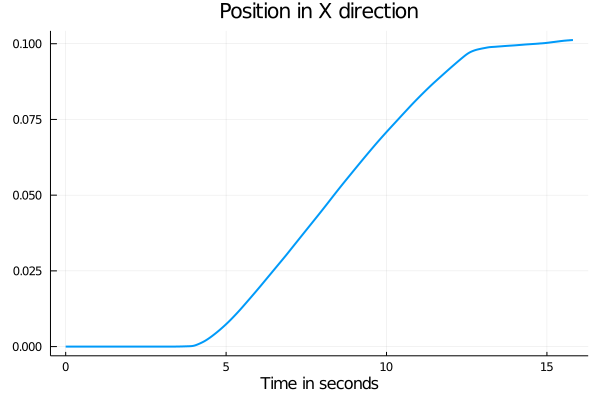

In [84]:
plot(train_data[1:7907,1],train_data[1:7907,2], title = "Position in X direction", label = false, lw = 2)
xlabel!("Time in seconds")

## MLP

### Custom Minibatch Function

In [85]:
function minibatch_custom(x, y, bs=100)
    num, den = divrem(size(x)[1],bs)
    number_of_minibatch = den == 0 ? num : num + 1
    data = Any[]
    nx = size(x)[1]
    ny = size(y)[1]
    remain = nx
    for i in 1:bs:nx
        residue = remain >= bs ? i+bs-1 : i+remain-1
        x_mb = convert(array_type,x[i:residue,:])
        y_mb = convert(array_type,y[i:residue,:])
        push!(data,(x_mb,y_mb))
        remain = remain - bs
    end
    return data
end

minibatch_custom (generic function with 2 methods)

In [86]:
dtrn = minibatch_custom(x_train,y_train);
dtst = minibatch_custom(x_test,y_test);

## Training

In [124]:
function init_params(ninputs::Int, noutputs::Int,scale = 1e-3)
    W = randn(noutputs,ninputs)*scale
    b = zeros(noutputs,1)
    return W,b
end

init_params (generic function with 2 methods)

In [117]:
#Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end

(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)